In [1]:
import json

# Load configuration and define a global variable
def load_config():
    global config
    with open('config_Deeprank.json') as config_file:
        config = json.load(config_file)

# Call the function to load the configuration
load_config()

In [2]:
import os
import pandas as pd
import json

# Load configuration and define a global variable
def load_config():
    global config
    with open('config_Deeprank.json') as config_file:
        config = json.load(config_file)

# Call the function to load the configuration
load_config()

# Specify the source directory where the CSV files are stored
source_directory = config['Deeprank_directory']

# Specify the base target directory where you want to save the Excel files
base_target_directory = config['output_directories']
subdirectory_name = 'Deep_TF_ex'

# Create the full target directory path including the subdirectory
full_target_directory = os.path.join(base_target_directory, subdirectory_name)

# Create the target directory including the subdirectory if it does not exist
if not os.path.exists(full_target_directory):
    os.makedirs(full_target_directory)

# Loop through all files in the source directory
for file_name in os.listdir(source_directory):
    if file_name.endswith('.csv'):
        # Construct the full path of the source file
        source_file_path = os.path.join(source_directory, file_name)
        
        # Load the CSV file
        df = pd.read_csv(source_file_path)
        
        # Construct the target file path with the .xlsx extension
        target_file_path = os.path.join(full_target_directory, file_name.replace('.csv', '.xlsx'))
        
        # Convert the DataFrame to an Excel file
        df.to_excel(target_file_path, index=False)

print("All CSV files have been converted to Excel files and saved in the new directory.")


All CSV files have been converted to Excel files and saved in the new directory.


In [3]:
import os
import pandas as pd


# Specify the source directory where the Excel files are stored
source_directory = os.path.join(config['output_directories'], 'Deep_TF_ex')

# Specify the base target directory where you want to save the processed Excel files
base_target_directory = config['output_directories']
subdirectory_name = 'Deep_TF_rank'

# Create the full target directory path including the subdirectory
full_target_directory = os.path.join(base_target_directory, subdirectory_name)

# Create the target directory including the subdirectory if it does not exist
if not os.path.exists(full_target_directory):
    os.makedirs(full_target_directory)

# Process each Excel file in the source directory
for file_name in os.listdir(source_directory):
    if file_name.endswith('.xlsx'):
        # Load the Excel file
        source_file_path = os.path.join(source_directory, file_name)
        df = pd.read_excel(source_file_path)

        # Filter rows where 'Filename' starts with 'ranked'
        df_filtered = df[df['CSV Name'].str.startswith('ranked')]

        # Sort the filtered DataFrame based on the 'Value' column from largest to smallest
        df_sorted = df_filtered.sort_values(by='Prediction Value', ascending=False)

        # Add the 'dove rank' column, starting from 0
        df_sorted['deep rank'] = range(len(df_sorted))

        # Construct the target file path with subdirectory
        target_file_path = os.path.join(full_target_directory, file_name.replace('.xlsx', '_ranked.xlsx'))
        
        # Save the processed DataFrame to a new Excel file
        df_sorted.to_excel(target_file_path, index=False)

print("All files have been processed and saved in the target directory.")


All files have been processed and saved in the target directory.


In [4]:
import os

def rename_files_in_directory(directory_path):
    # Iterate over all files in the directory
    for filename in os.listdir(directory_path):
        # Check if the filename contains the character to be replaced
        if '-' in filename:
            # Construct the new filename by replacing "-" with "_"
            new_filename = filename.replace('-', '_')
            # Construct the full old and new file paths
            old_file_path = os.path.join(directory_path, filename)
            new_file_path = os.path.join(directory_path, new_filename)
            # Rename the file
            os.rename(old_file_path, new_file_path)
            #print(f'Renamed "{filename}" to "{new_filename}"')

# Specify the directory path
directory_path = os.path.join(config['output_directories'], 'Deep_TF_rank')

# Call the function
rename_files_in_directory(directory_path)


In [6]:
import os
import shutil
import pandas as pd
from openpyxl import load_workbook

def extract_pdb_id_from_dockq(filename):
    """Extracts the PDB ID from a DockQ filename."""
    parts = filename.split('_')
    return parts[0]  # PDB ID is the first part

def extract_pdb_id_from_Deep(filename):
    """Extracts the PDB ID from a Deep filename."""
    parts = filename.split('_')
    return parts[1]  # PDB ID is after 'Deep_scoring'

def copy_Deep_sheets_to_dockq(dockq_dir, Deep_dir, base_output_dir, subdirectory_name):
    # Create full output directory path including the subdirectory
    full_output_dir = os.path.join(base_output_dir, subdirectory_name)
    
    # Create the subdirectory if it does not exist
    if not os.path.exists(full_output_dir):
        os.makedirs(full_output_dir)
    
    dockq_files = os.listdir(dockq_dir)
    Deep_files = os.listdir(Deep_dir)
    
    # Map Deep files to their PDB IDs
    Deep_map = {extract_pdb_id_from_Deep(f).upper(): f for f in Deep_files if 'ranked' in f}
    
    for dockq_file in dockq_files:
        if dockq_file.endswith('_TF.xlsx') and 'DockQ_data' in dockq_file:
            pdb_id = extract_pdb_id_from_dockq(dockq_file).upper()
            if pdb_id in Deep_map:
                dockq_path = os.path.join(dockq_dir, dockq_file)
                Deep_path = os.path.join(Deep_dir, Deep_map[pdb_id])
                output_path = os.path.join(full_output_dir, dockq_file)
                
                # Copy the DockQ file to the output directory if it's not already there
                if not os.path.exists(output_path):
                    shutil.copyfile(dockq_path, output_path)
                
                print(f"Processing {dockq_file} and {Deep_map[pdb_id]} for PDB ID {pdb_id}")
                
                Deep_df = pd.read_excel(Deep_path, sheet_name='Sheet1')
                
                # Use the context to append to the existing workbook
                with pd.ExcelWriter(output_path, engine='openpyxl', mode='a') as writer:
                    book = writer.book  # Get the book from the writer
                    if 'Deep_GNN' in book.sheetnames:
                        std = book['Deep_GNN']
                        book.remove(std)
                    Deep_df.to_excel(writer, sheet_name='Deep_GNN', index=False)
                    
                    print(f'Updated {dockq_file} with Deep_GNN data for PDB ID {pdb_id}')
            else:
                print(f"No matching Deep_GNN file found for {dockq_file}")

# Use the previously loaded config
dockq_dir = config['TF_uni']
Deep_dir = os.path.join(config['output_directories'], 'Deep_TF_rank')
output_dir = config['output_directories']
subdirectory_name = 'Deep_DockQ_TF'

copy_Deep_sheets_to_dockq(dockq_dir, Deep_dir, output_dir, subdirectory_name)


Processing 7R2M_DockQ_data_TF.xlsx and TF_7r2m_ranked.xlsx for PDB ID 7R2M
Updated 7R2M_DockQ_data_TF.xlsx with Deep_GNN data for PDB ID 7R2M
Processing 8EBL_DockQ_data_TF.xlsx and TF_8ebl_ranked.xlsx for PDB ID 8EBL
Updated 8EBL_DockQ_data_TF.xlsx with Deep_GNN data for PDB ID 8EBL
Processing 7UW2_DockQ_data_TF.xlsx and TF_7uw2_ranked.xlsx for PDB ID 7UW2
Updated 7UW2_DockQ_data_TF.xlsx with Deep_GNN data for PDB ID 7UW2
Processing 7ZX4_DockQ_data_TF.xlsx and TF_7zx4_ranked.xlsx for PDB ID 7ZX4
Updated 7ZX4_DockQ_data_TF.xlsx with Deep_GNN data for PDB ID 7ZX4
Processing 7UE2_DockQ_data_TF.xlsx and TF_7ue2_ranked.xlsx for PDB ID 7UE2
Updated 7UE2_DockQ_data_TF.xlsx with Deep_GNN data for PDB ID 7UE2
Processing 8CCW_DockQ_data_TF.xlsx and TF_8ccw_ranked.xlsx for PDB ID 8CCW
Updated 8CCW_DockQ_data_TF.xlsx with Deep_GNN data for PDB ID 8CCW
Processing 8CIR_DockQ_data_TF.xlsx and TF_8cir_ranked.xlsx for PDB ID 8CIR
Updated 8CIR_DockQ_data_TF.xlsx with Deep_GNN data for PDB ID 8CIR
Proces

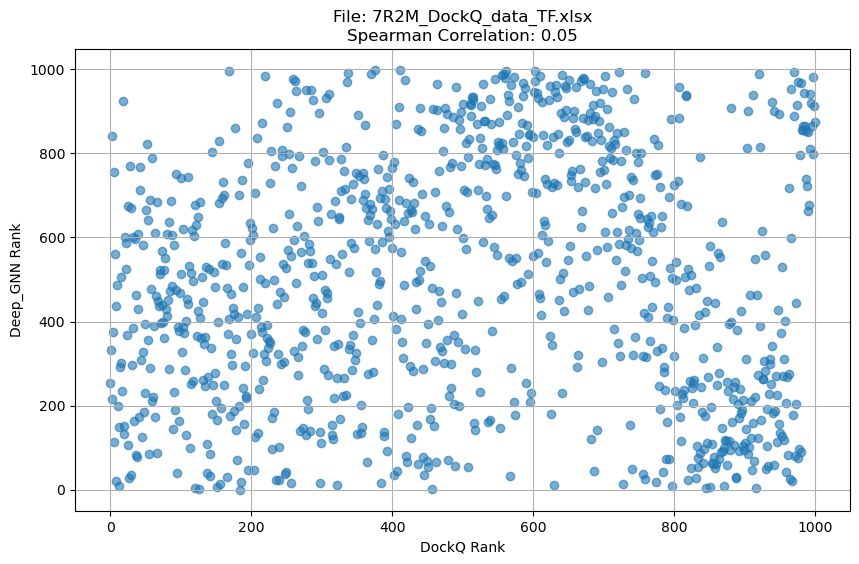

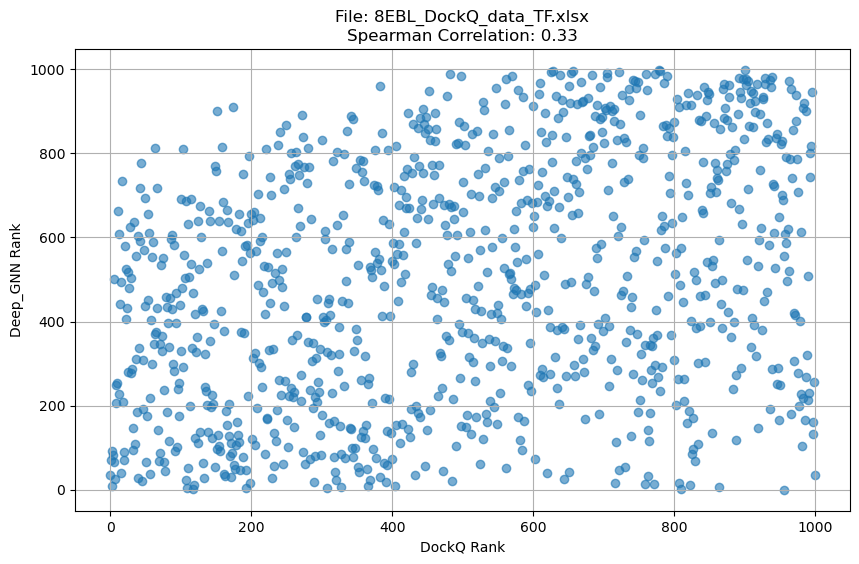

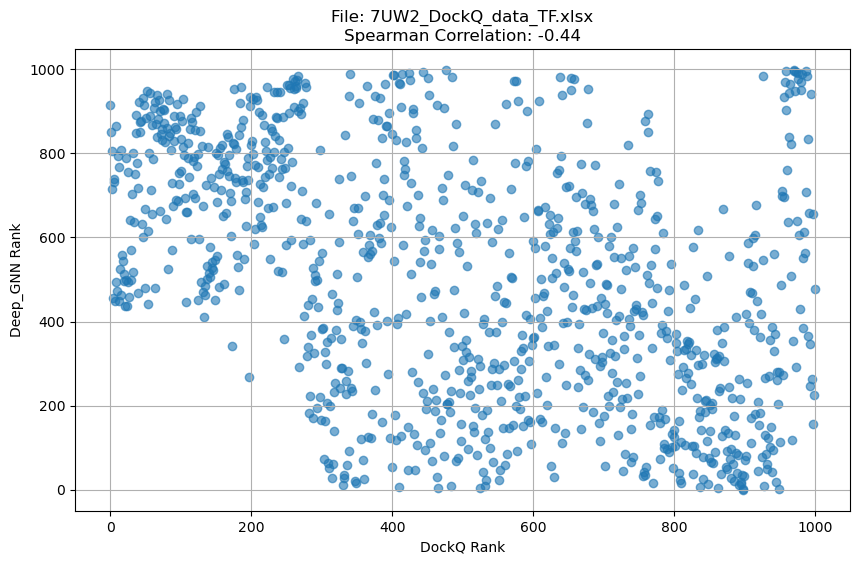

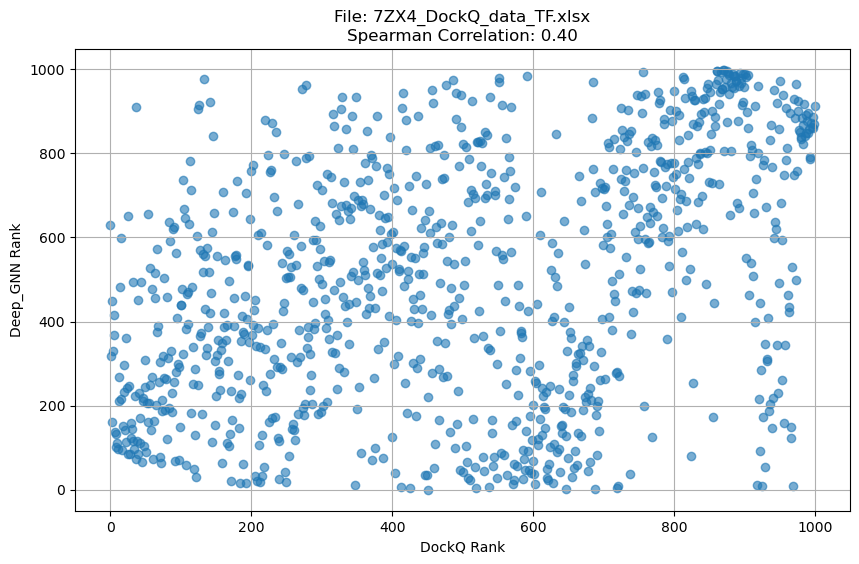

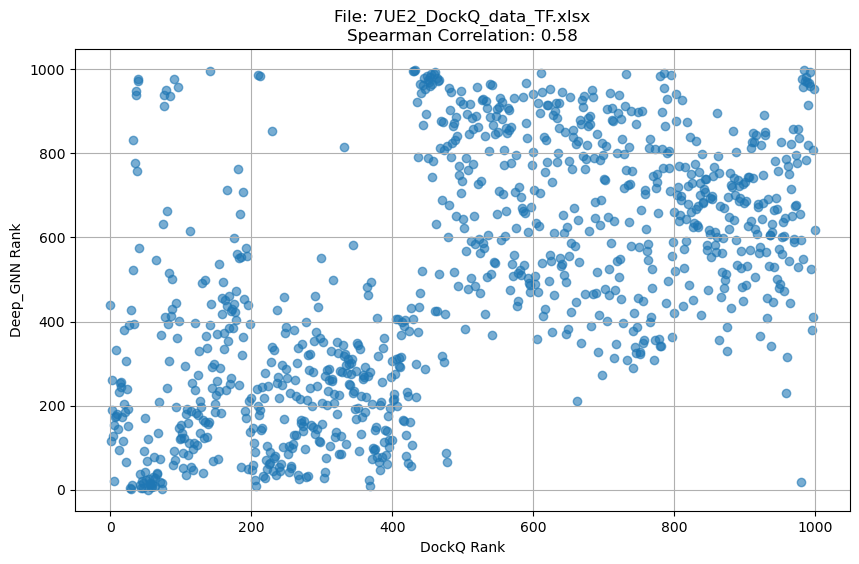

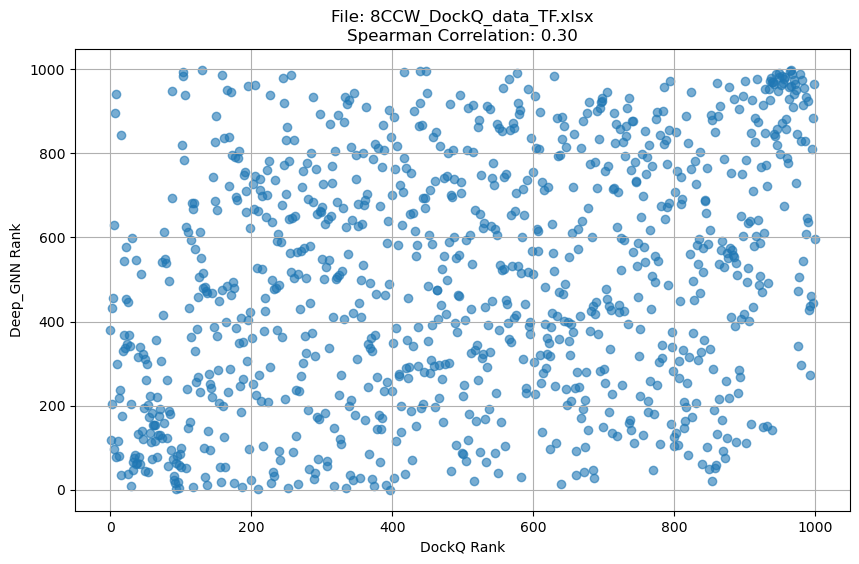

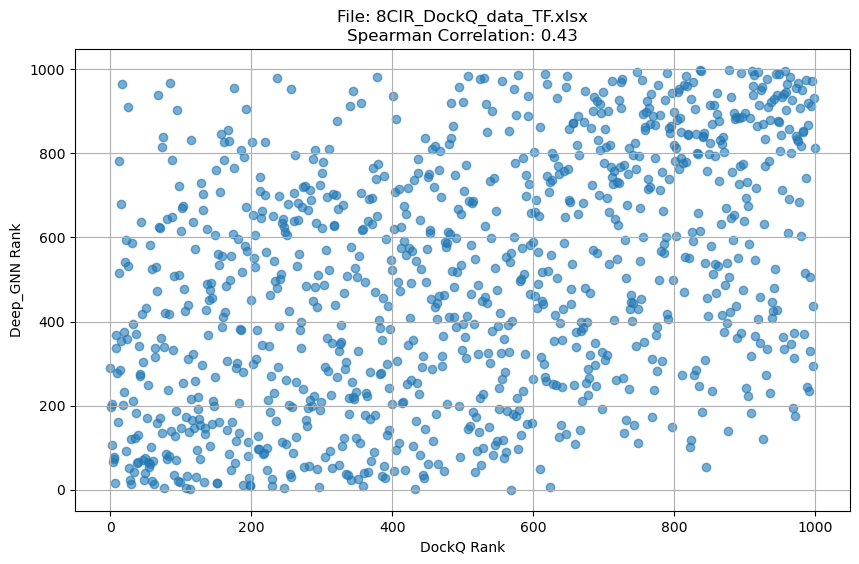

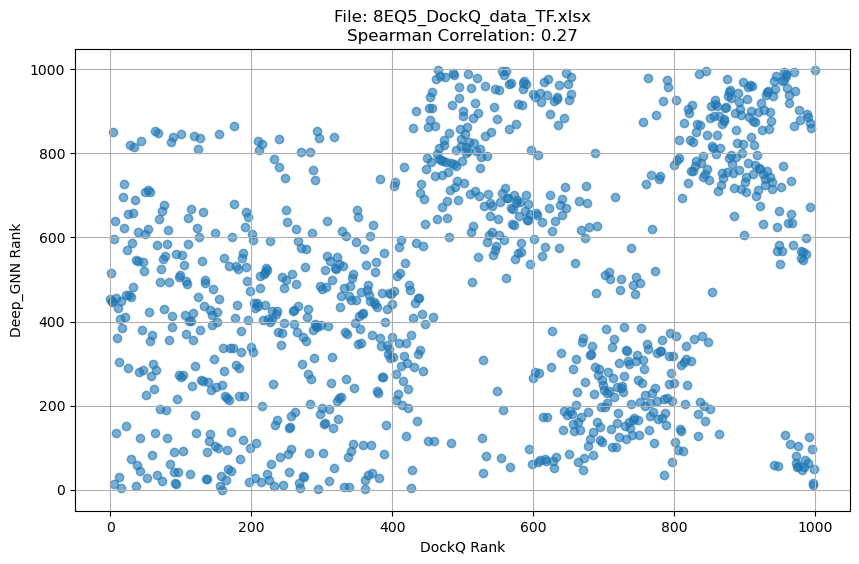

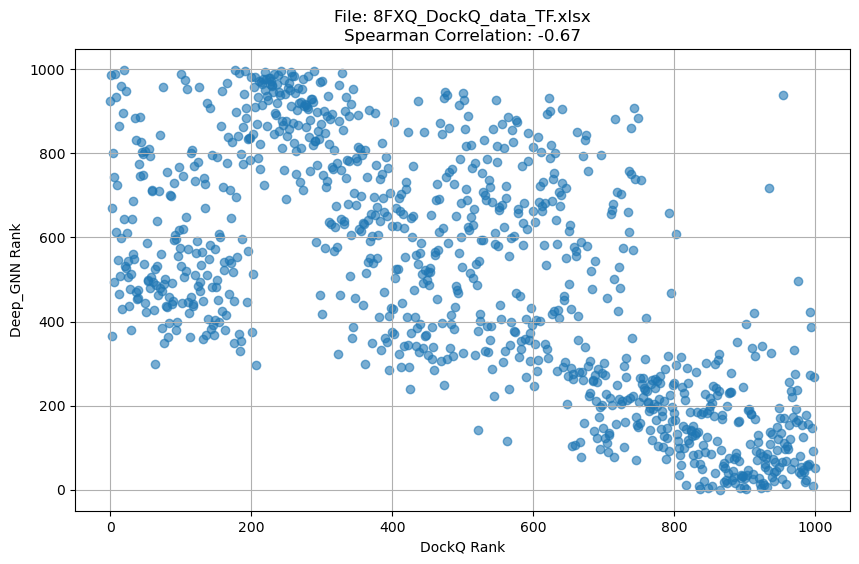

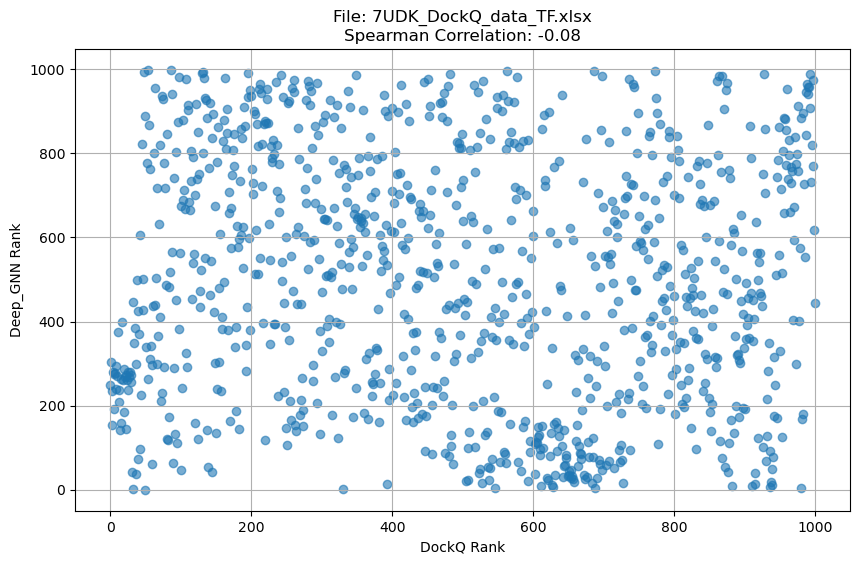

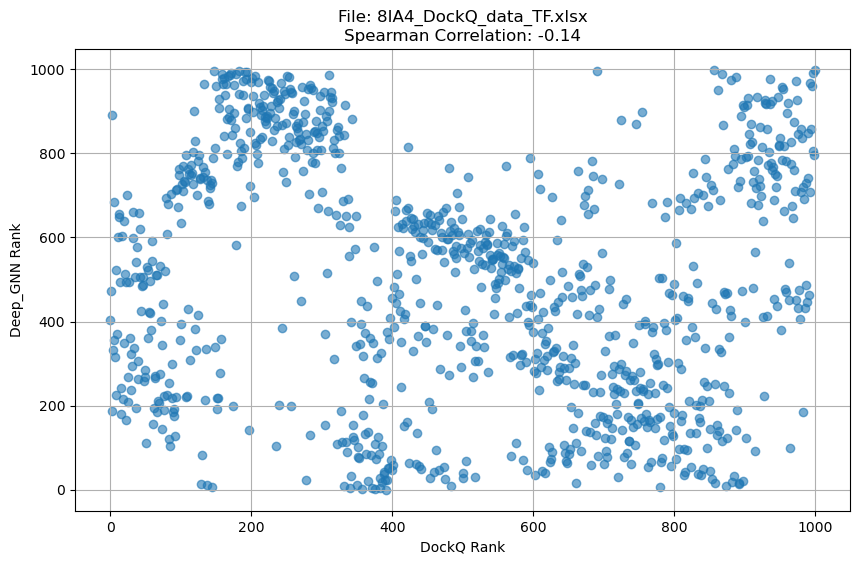

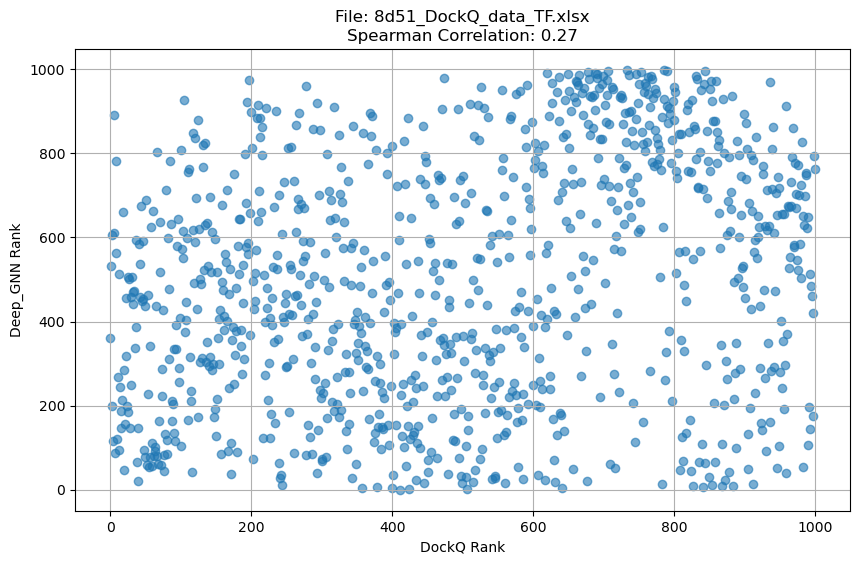

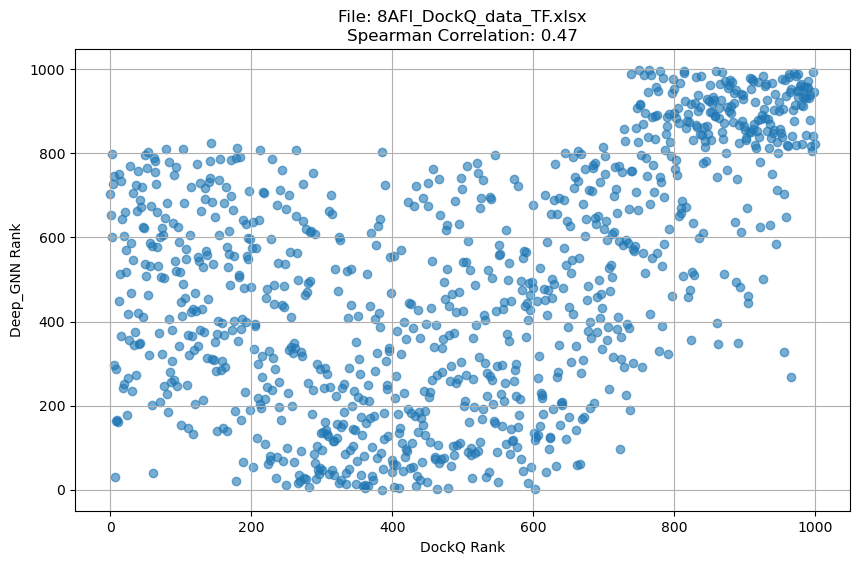

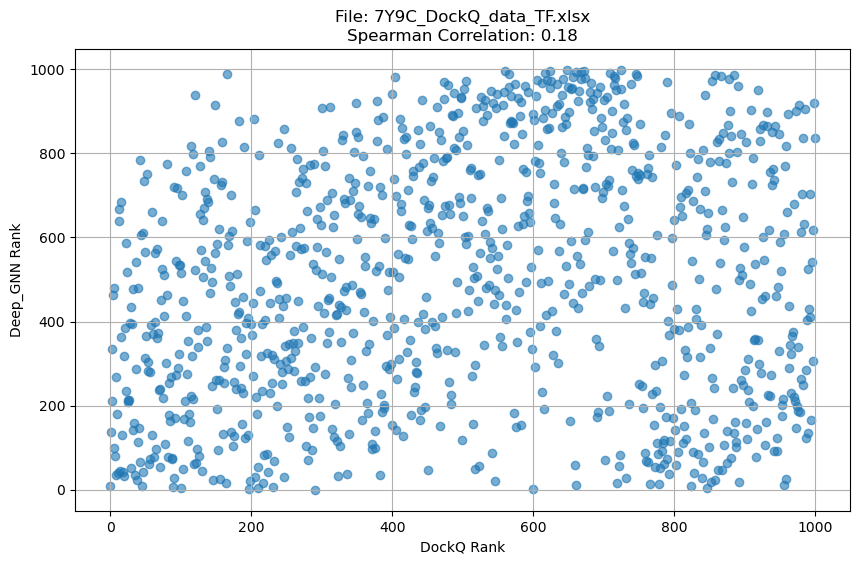

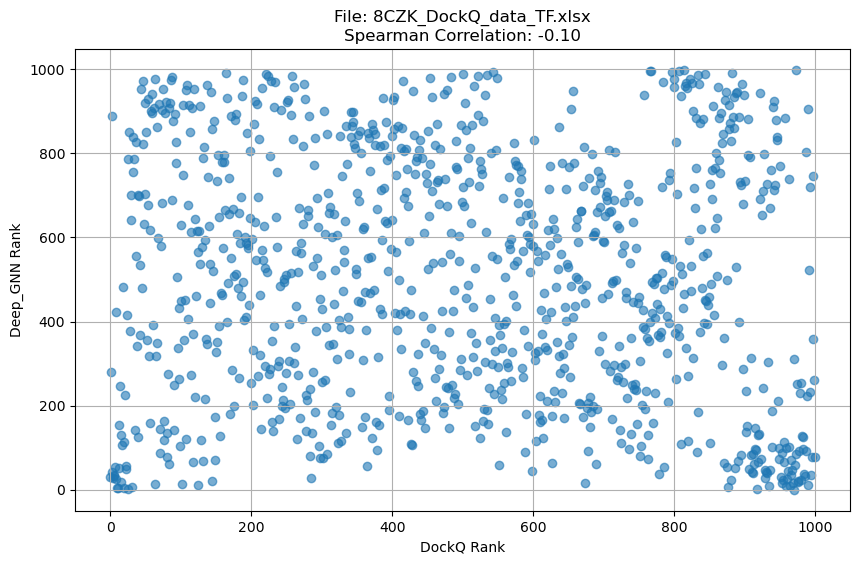

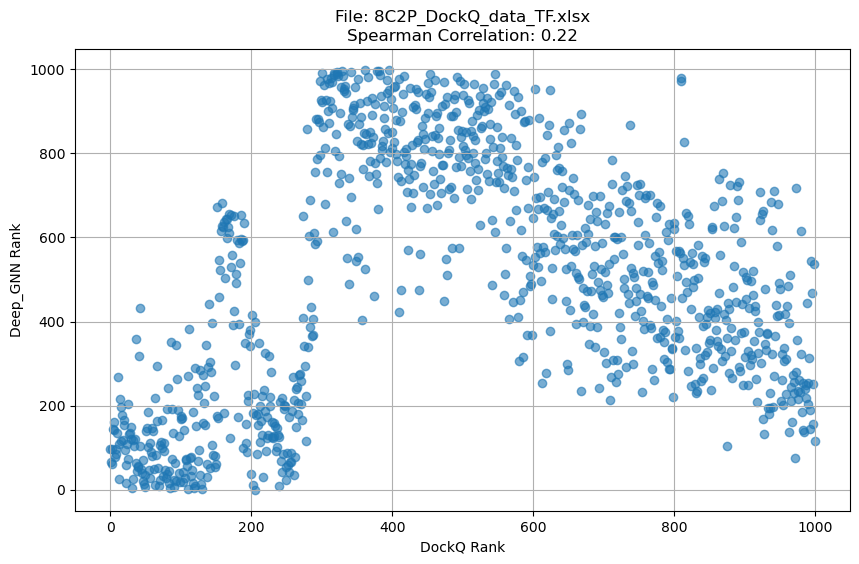

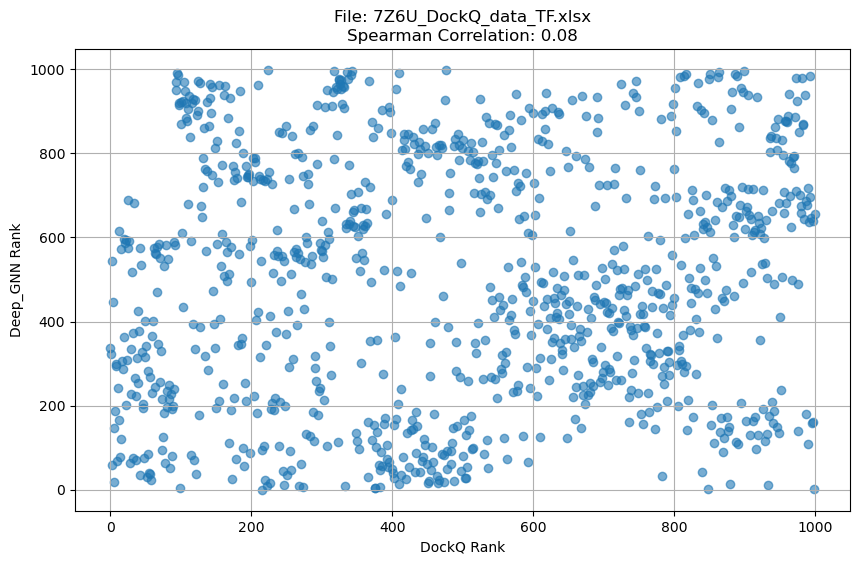

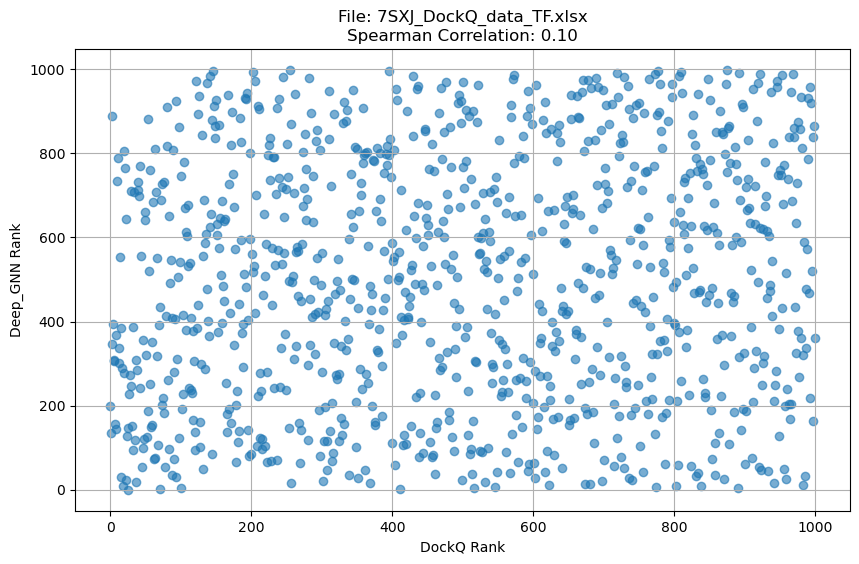

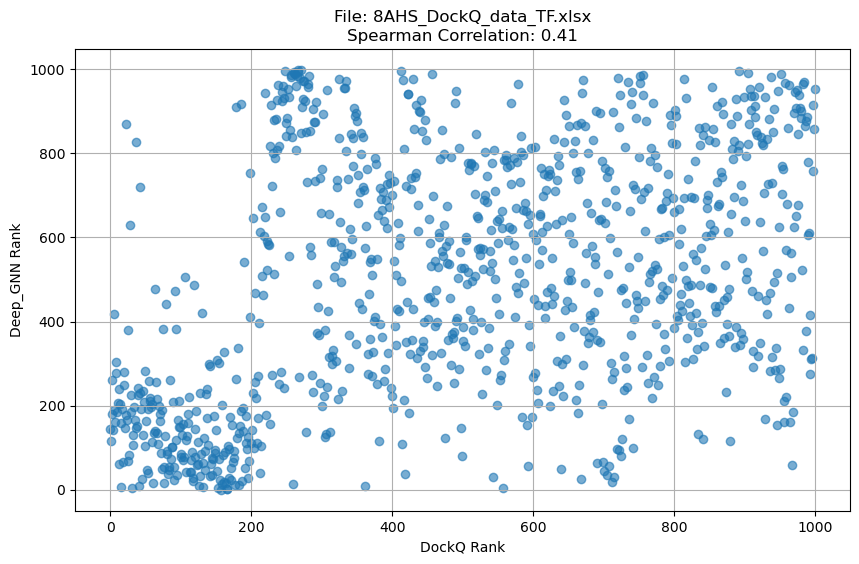

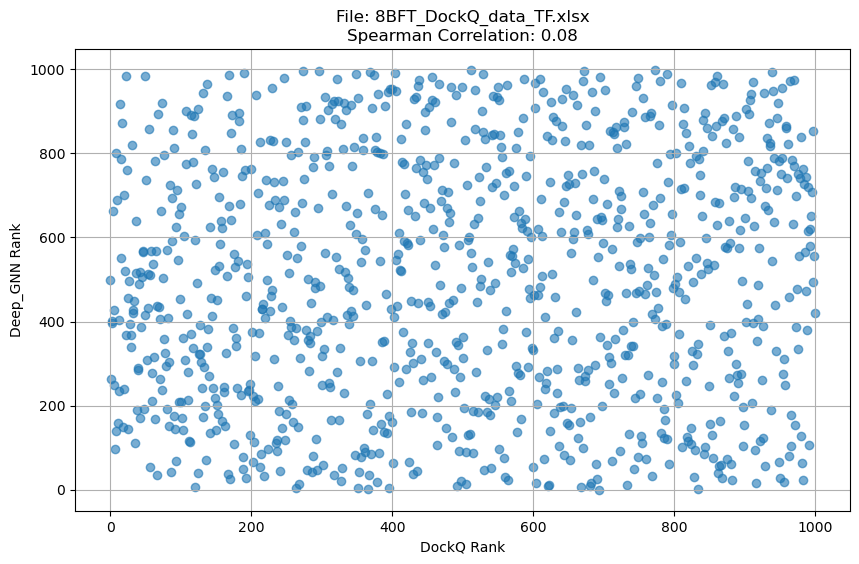

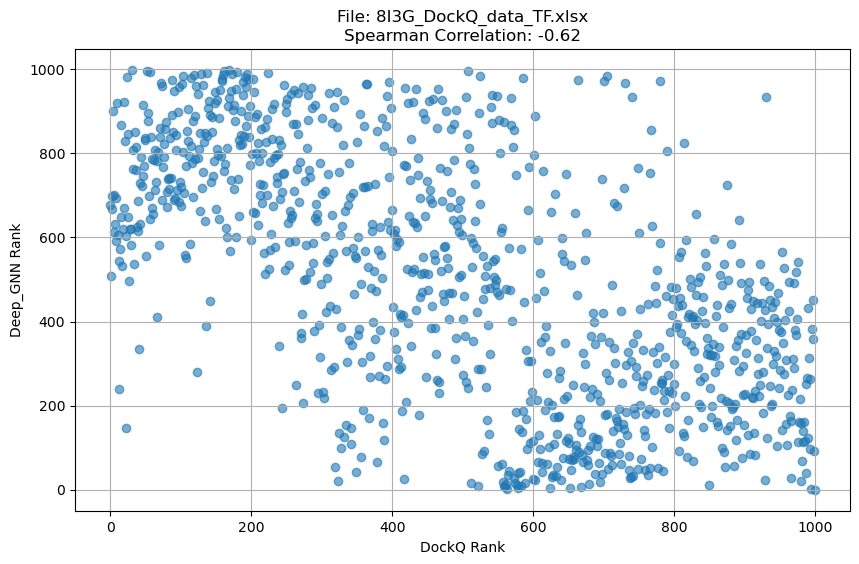

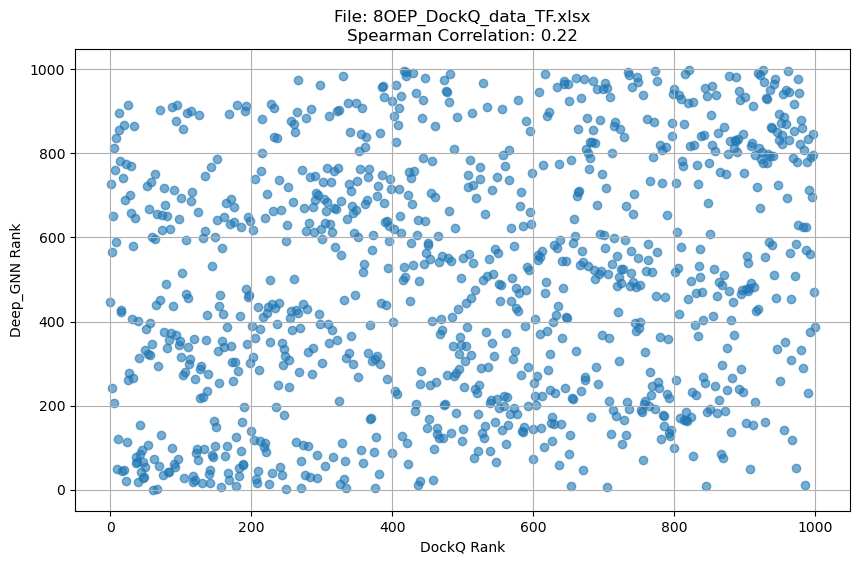

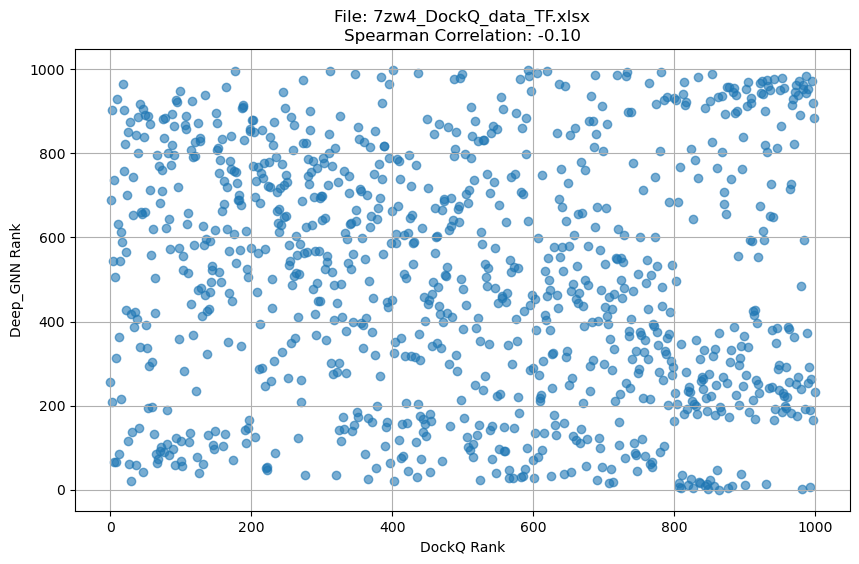

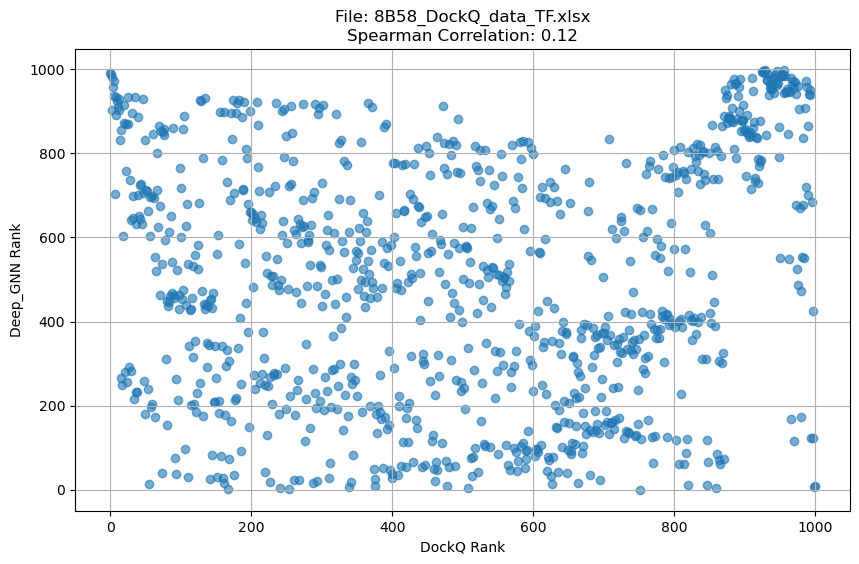

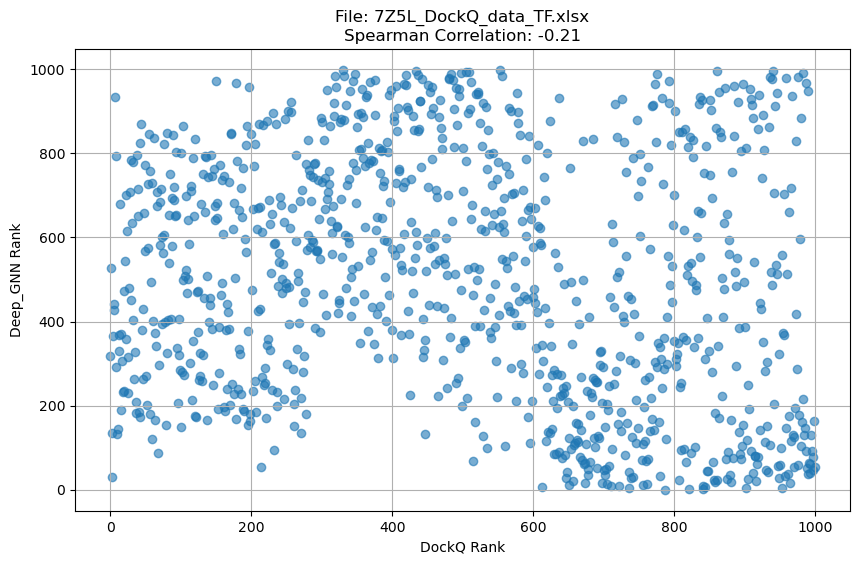

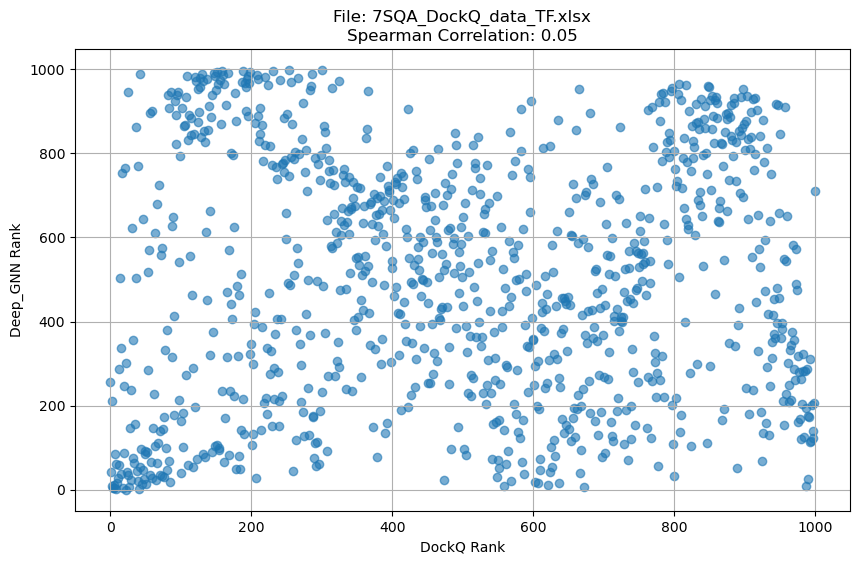

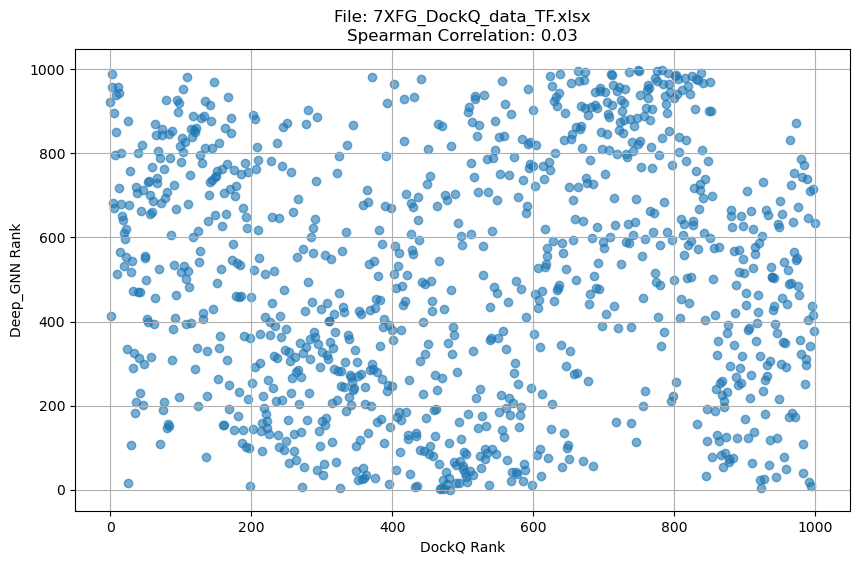

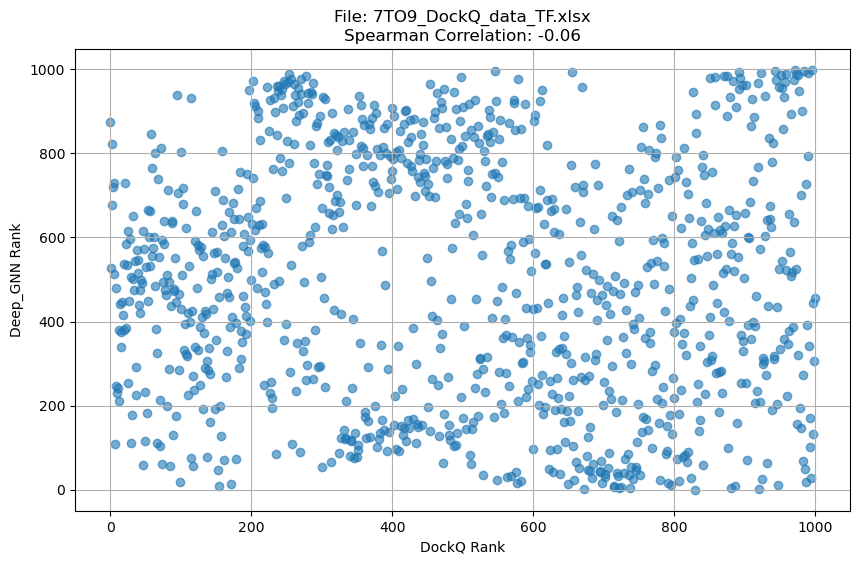

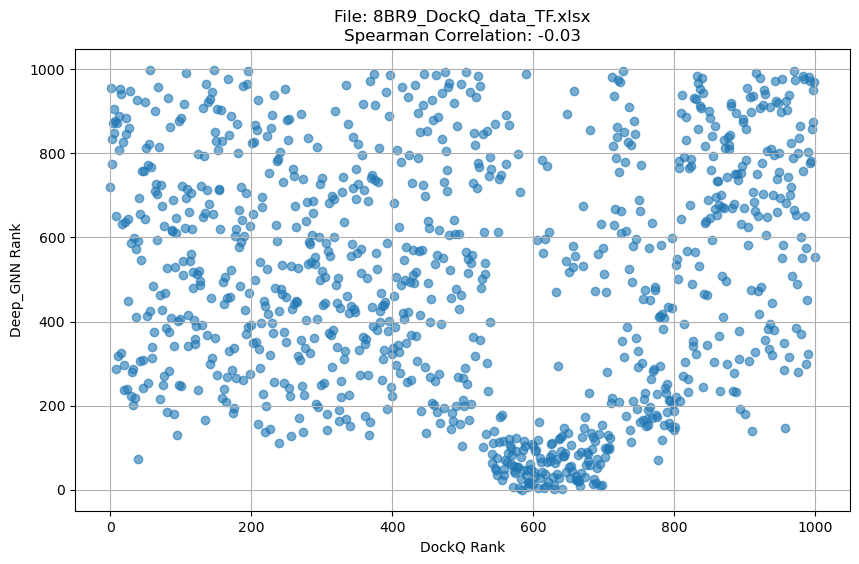

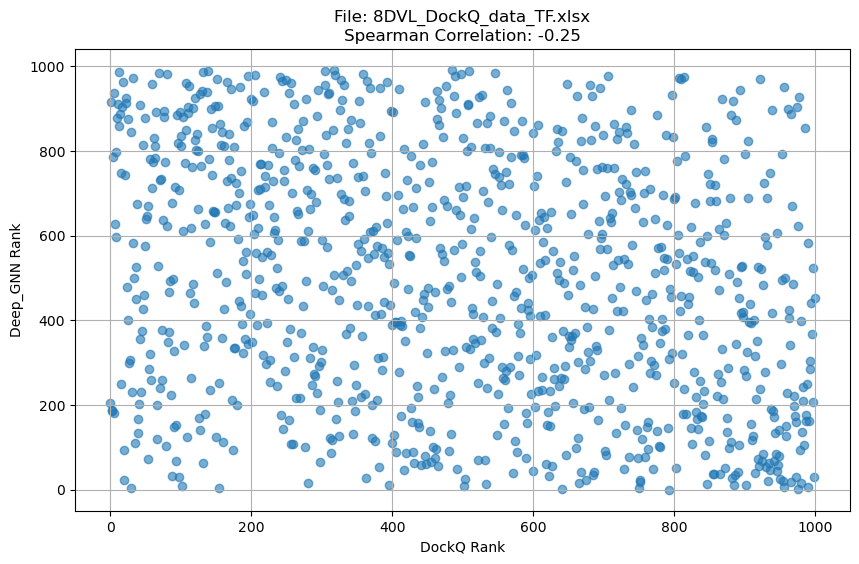

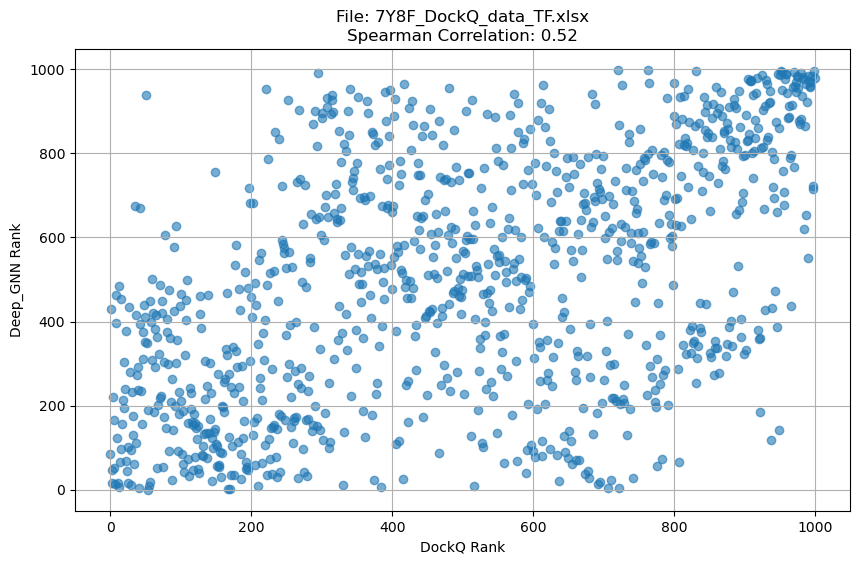

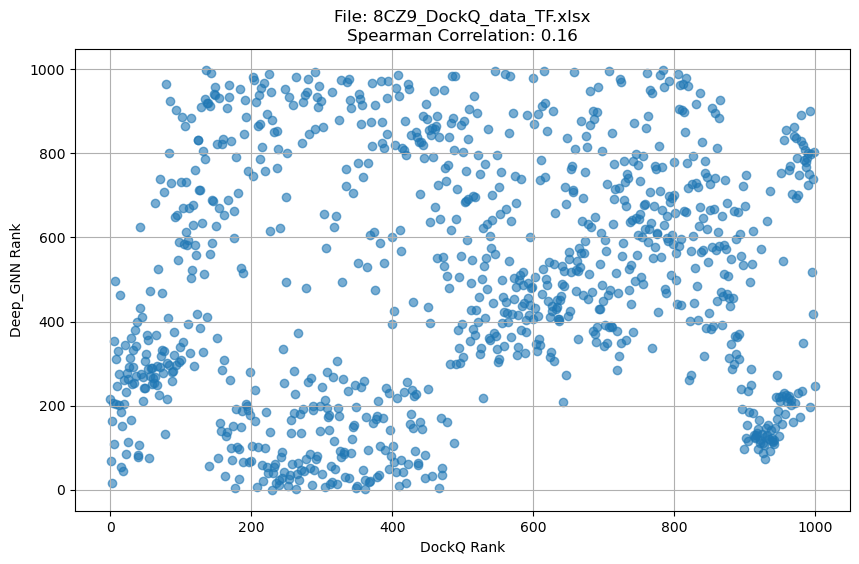

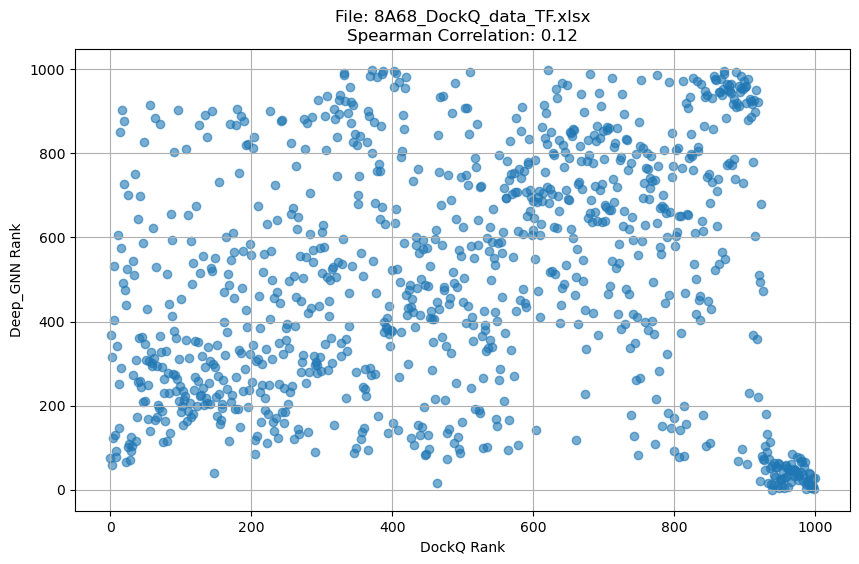

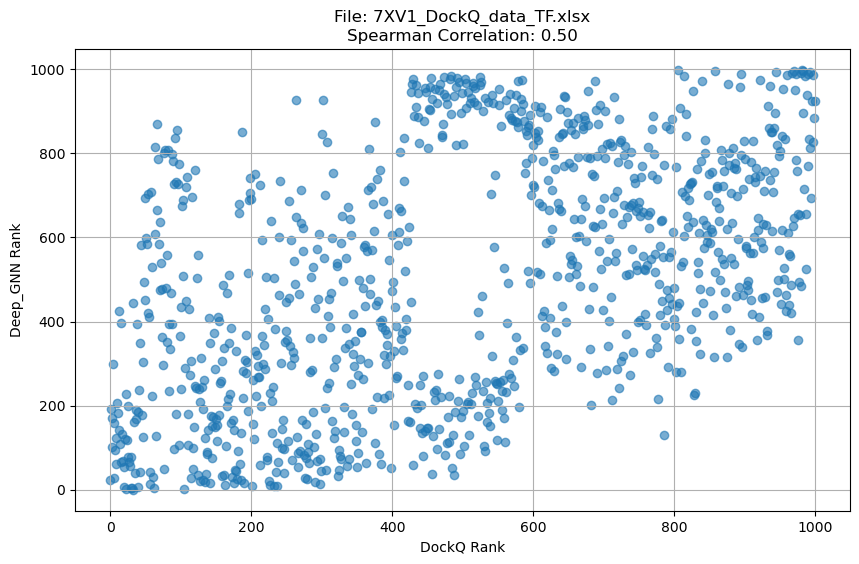

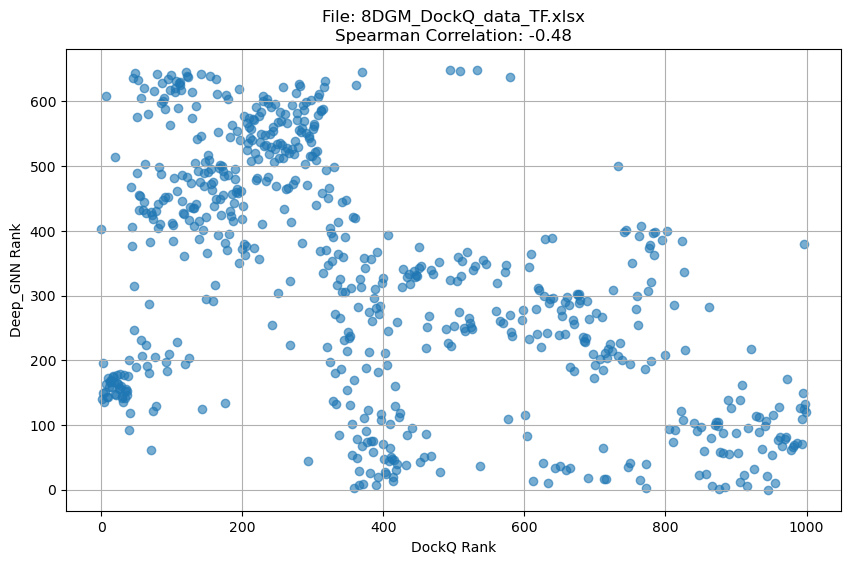

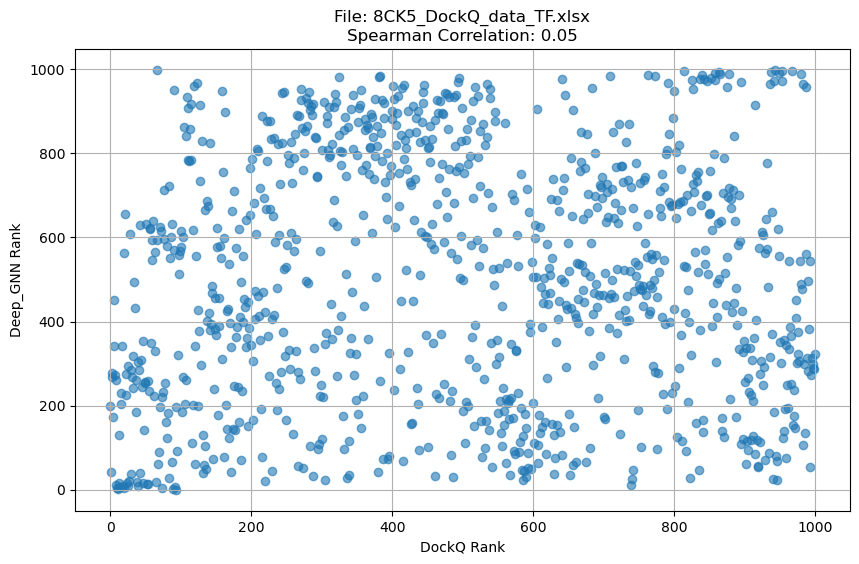

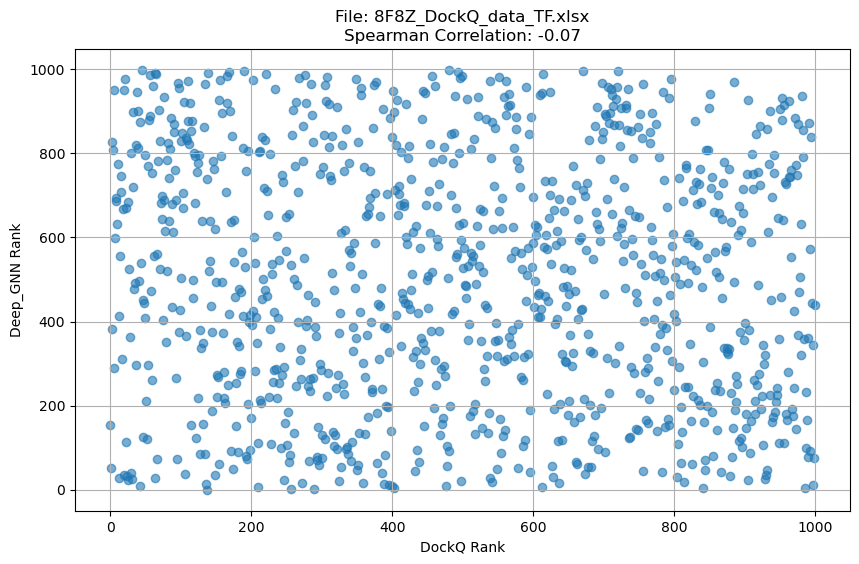

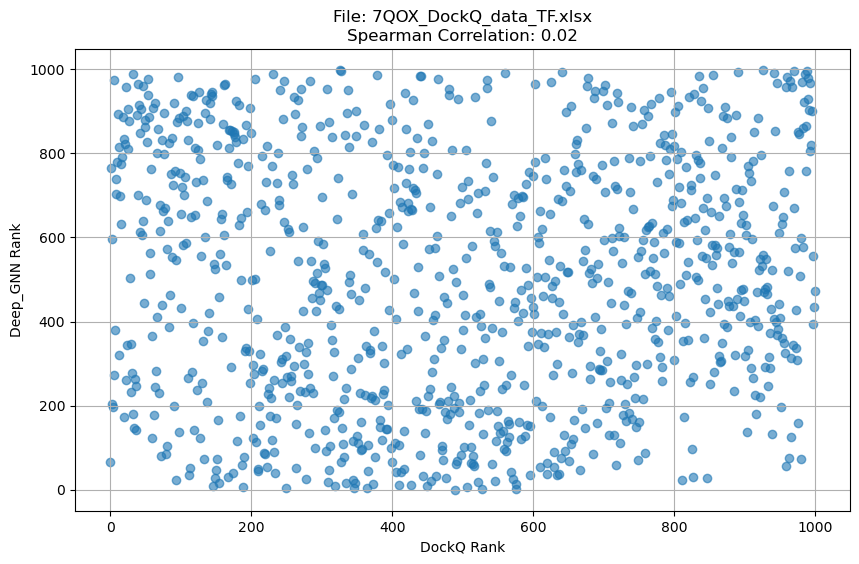

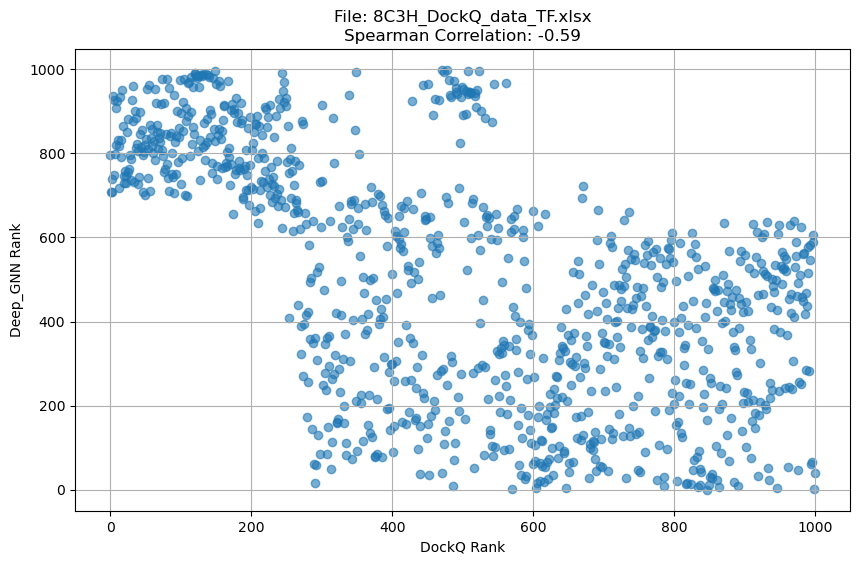

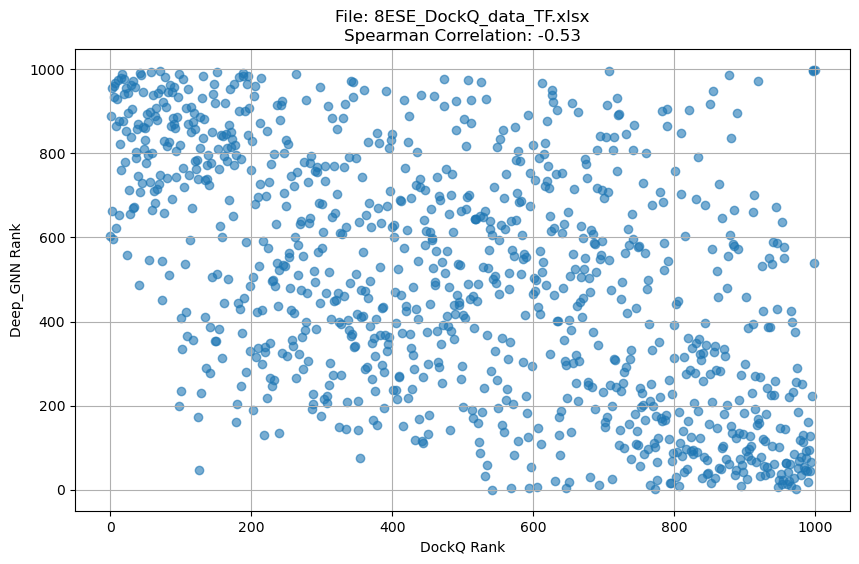

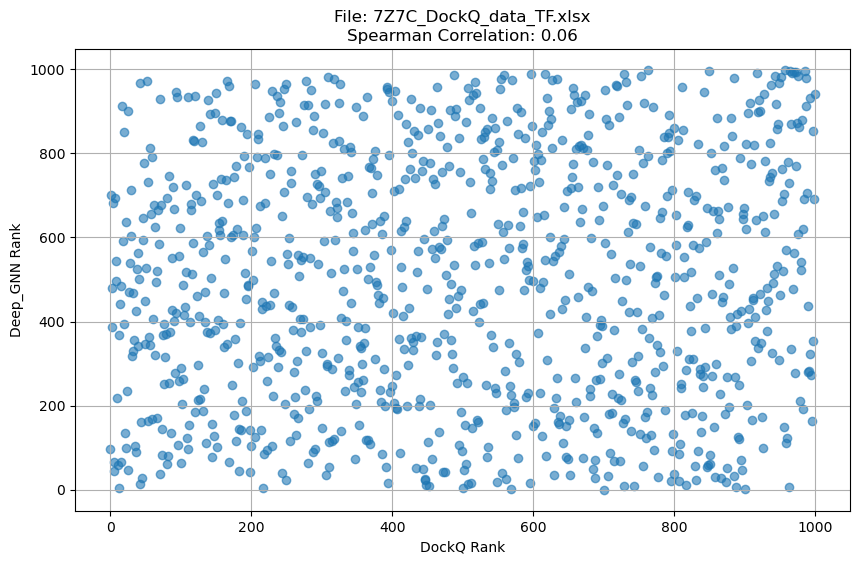

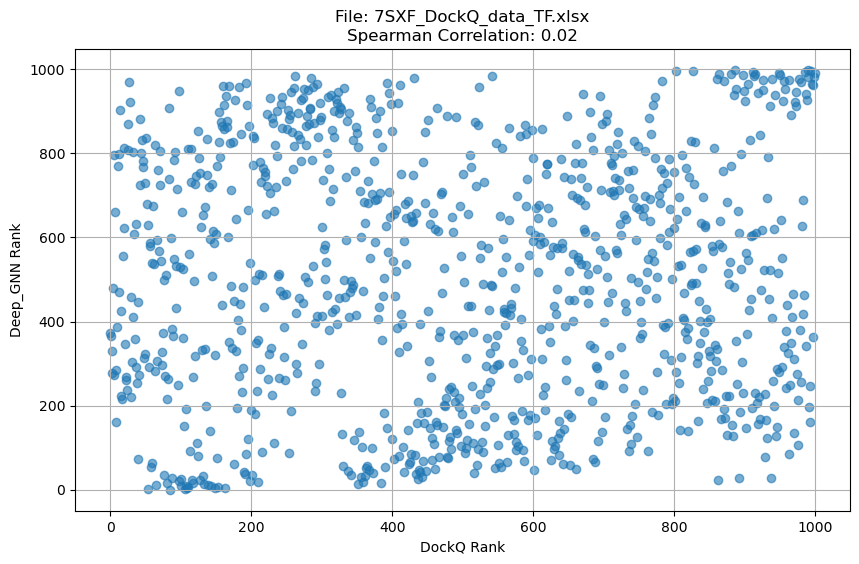

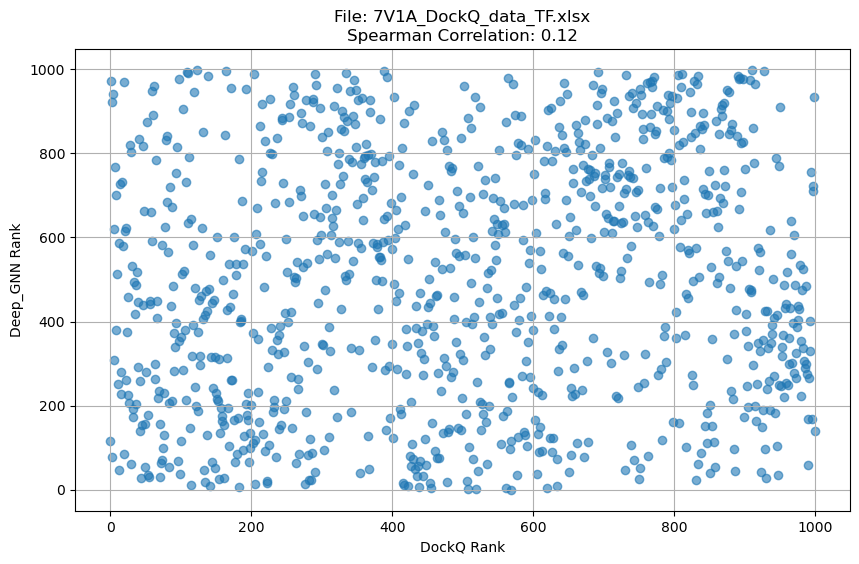

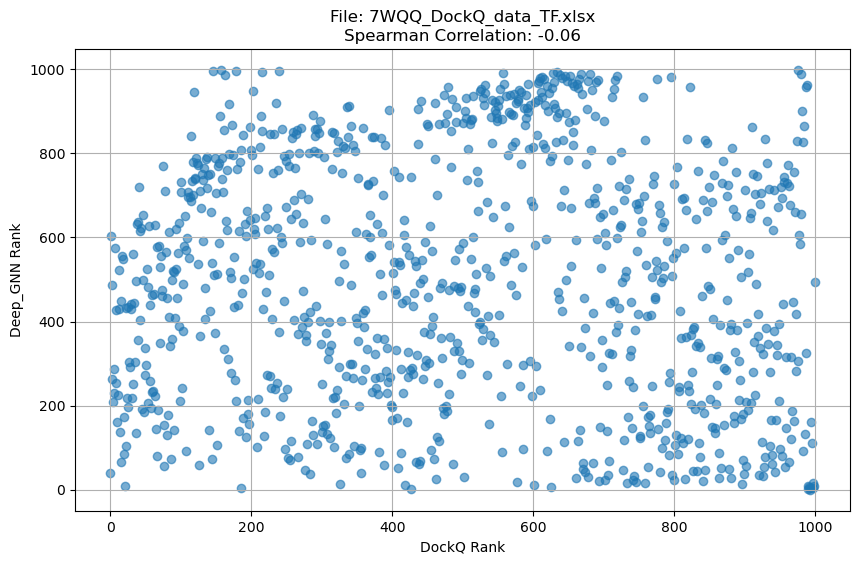

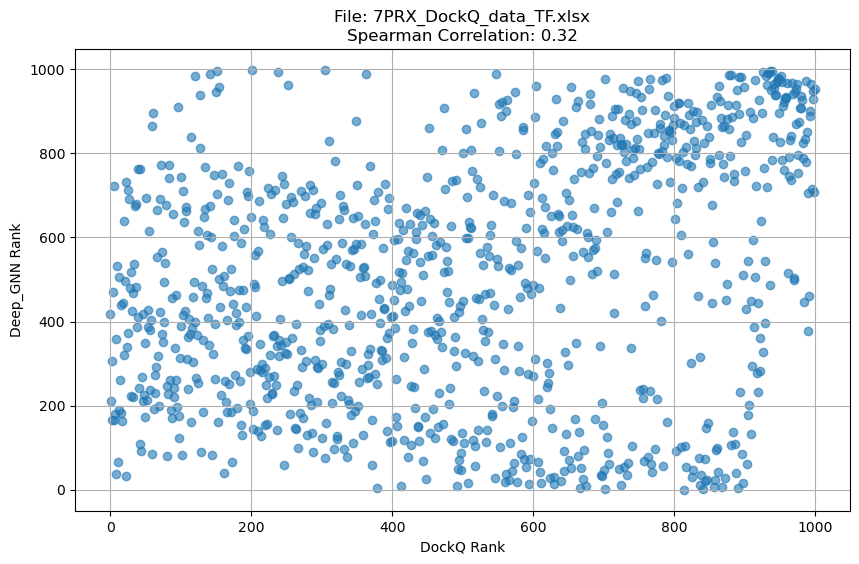

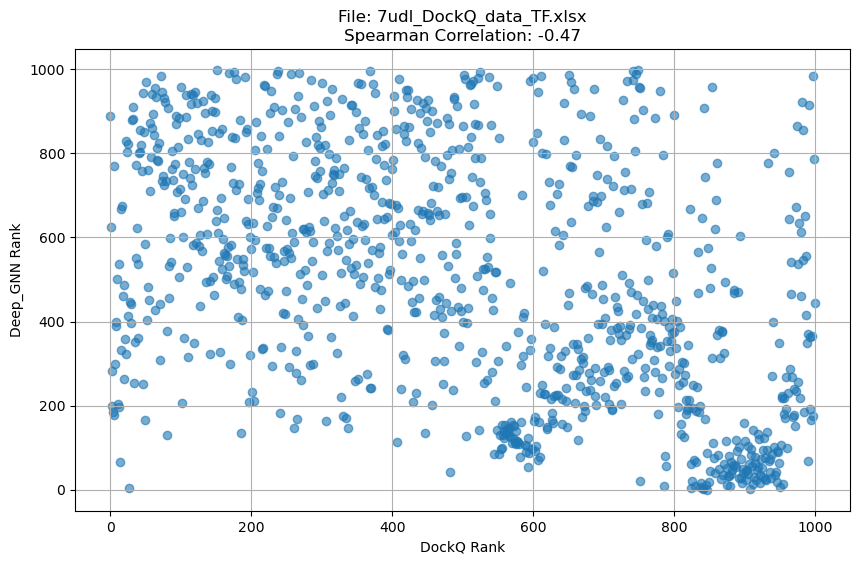

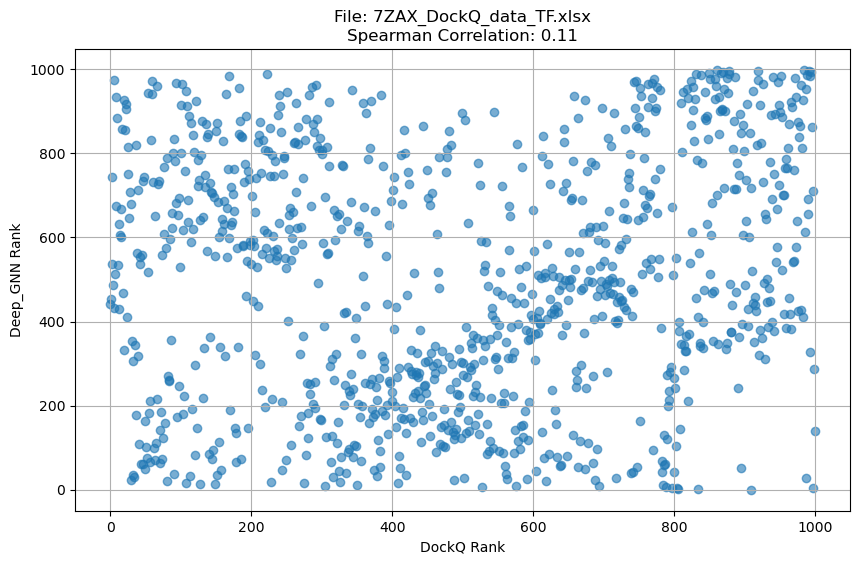

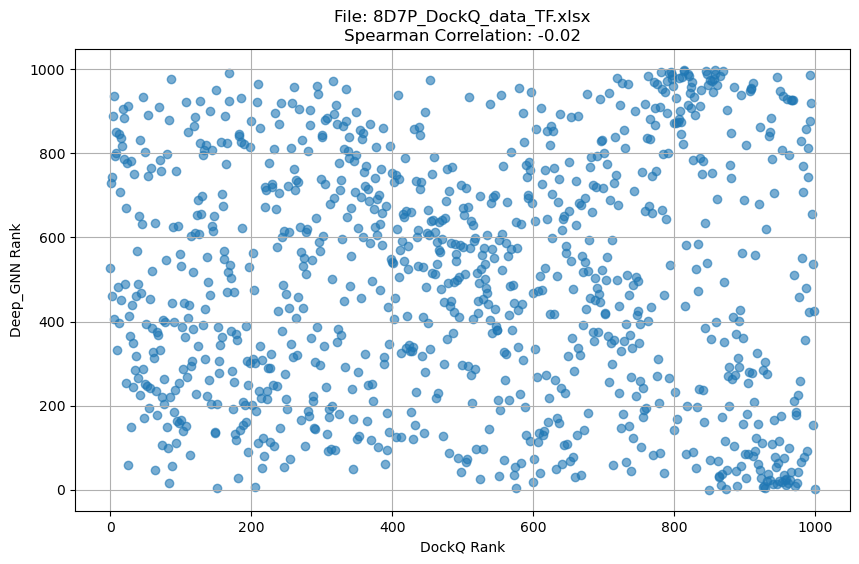

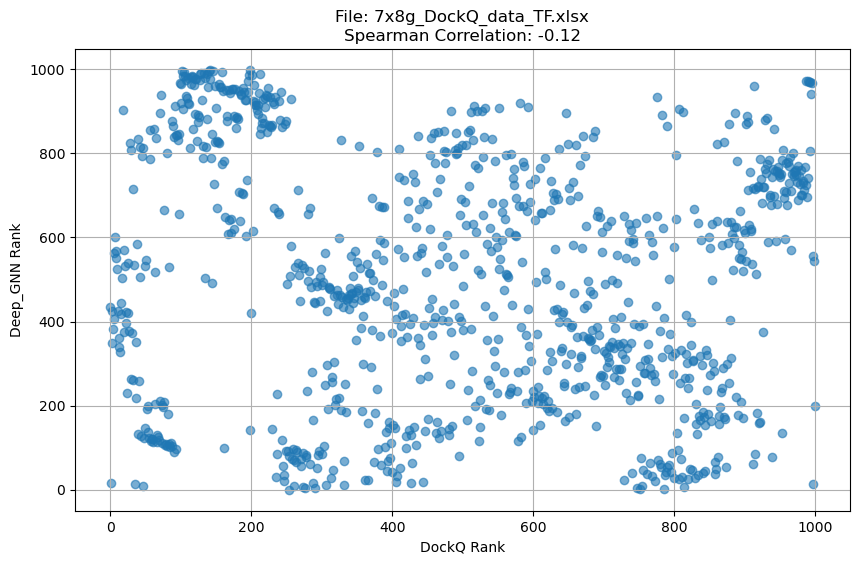

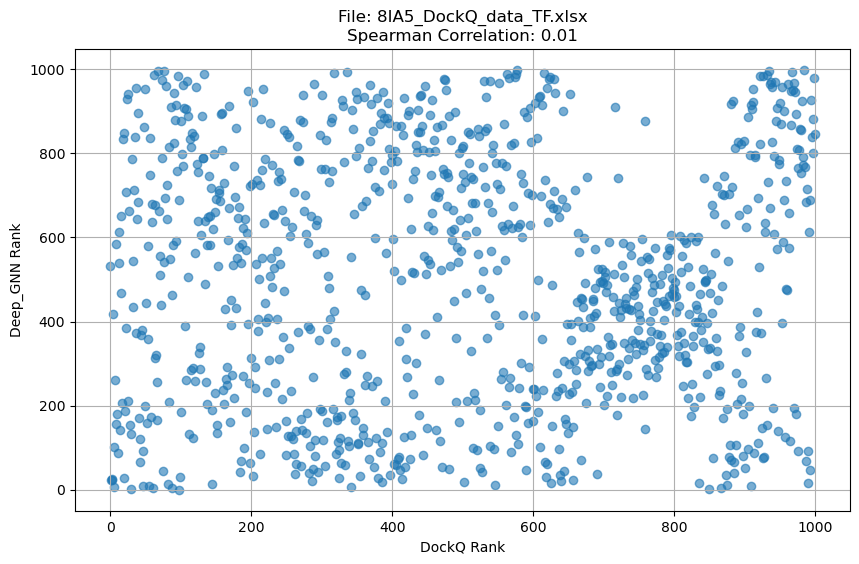

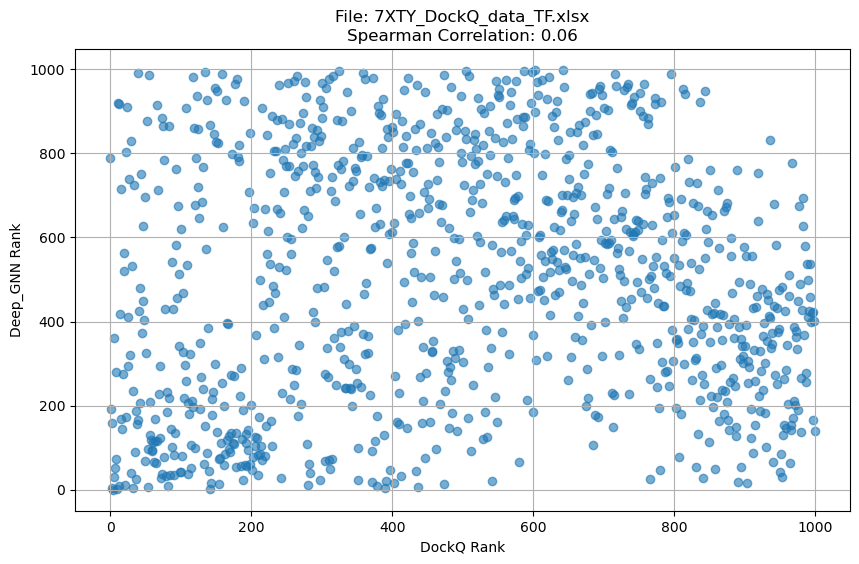

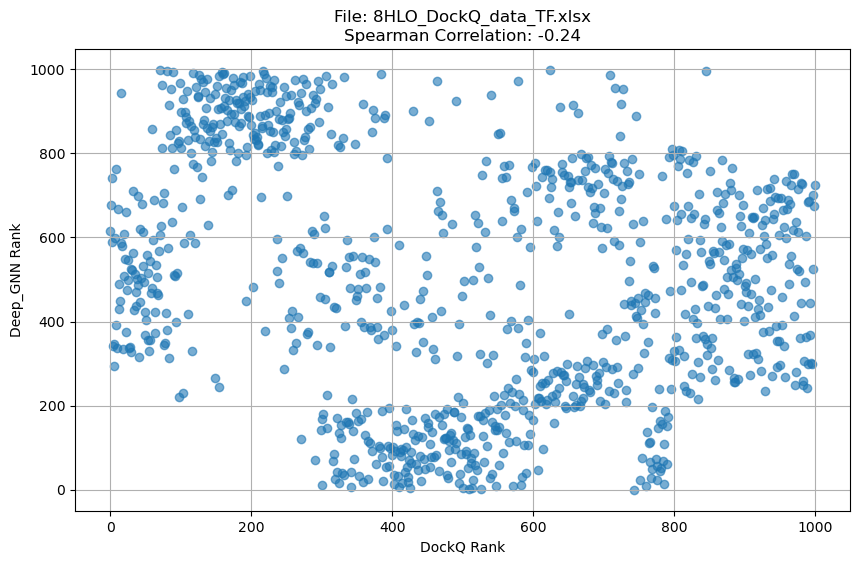

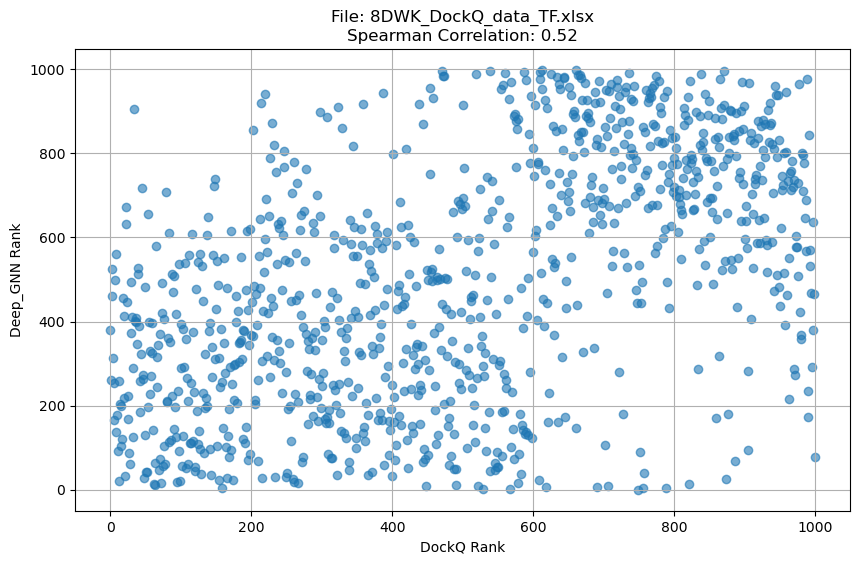

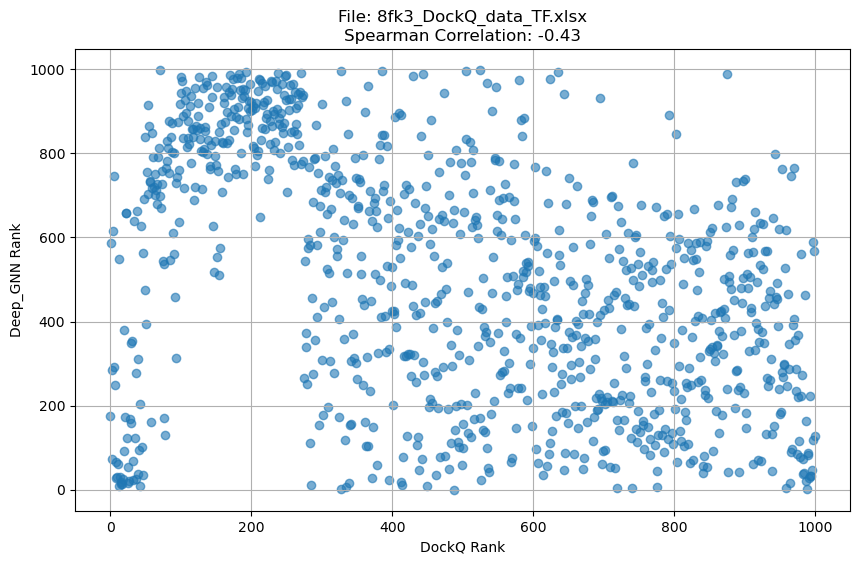

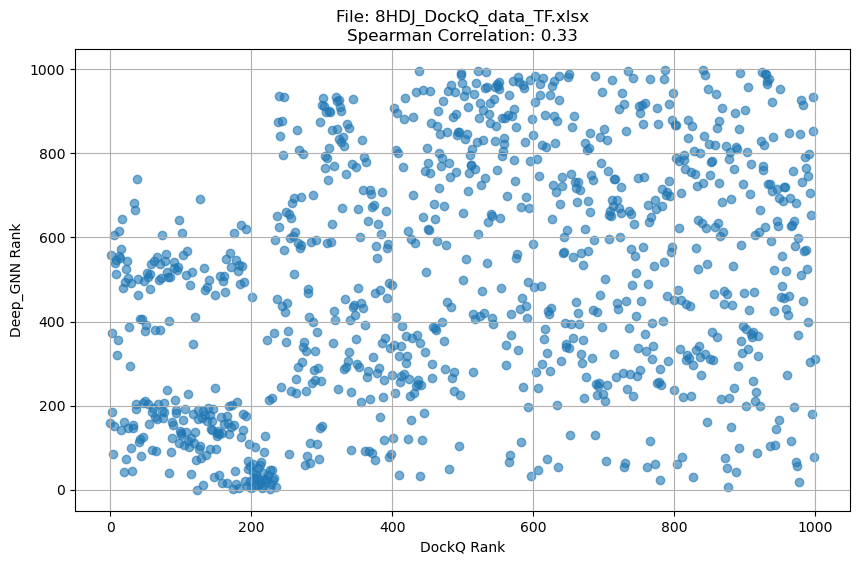

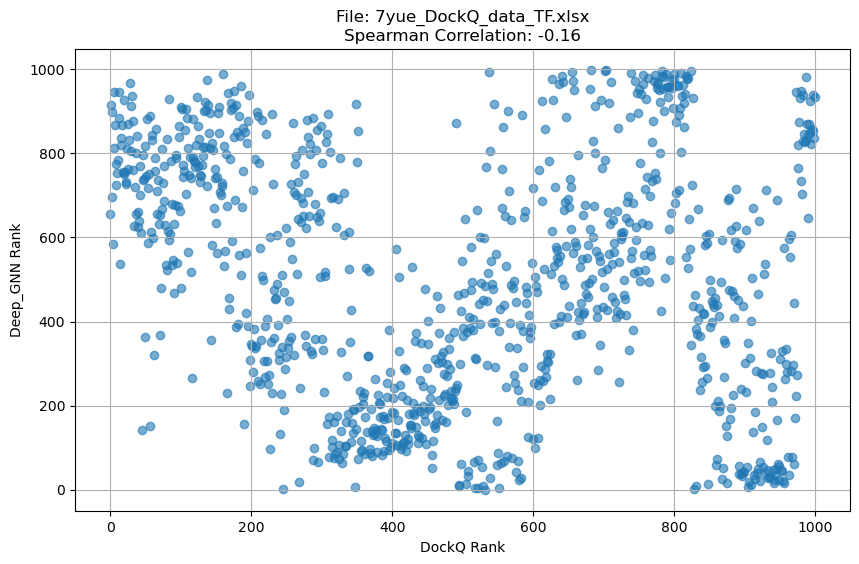

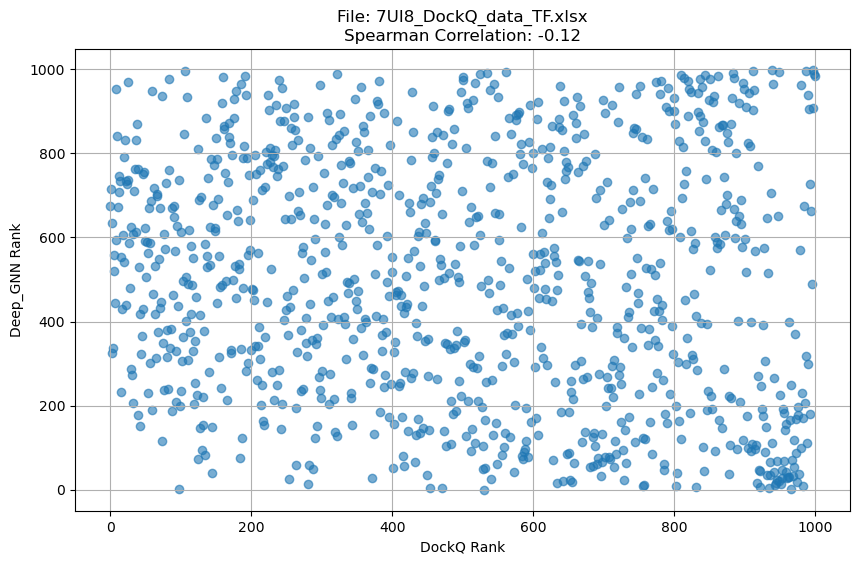

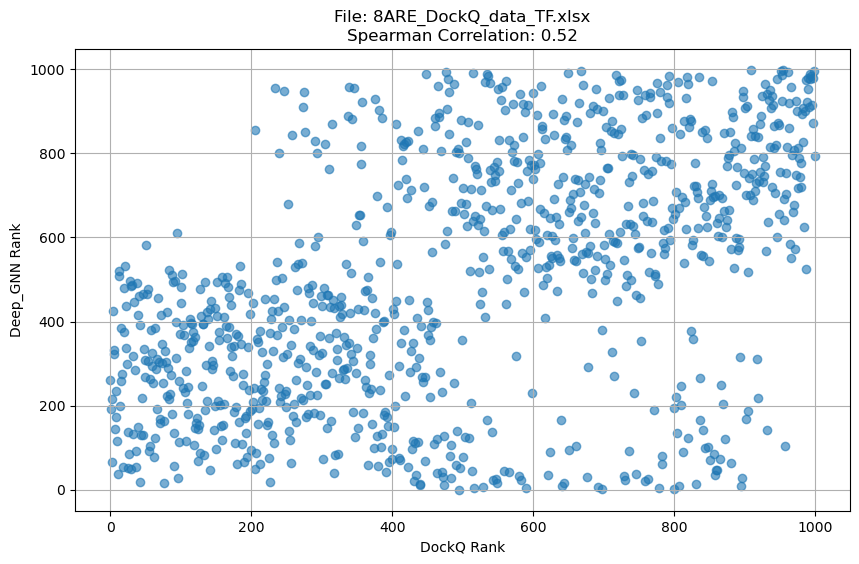

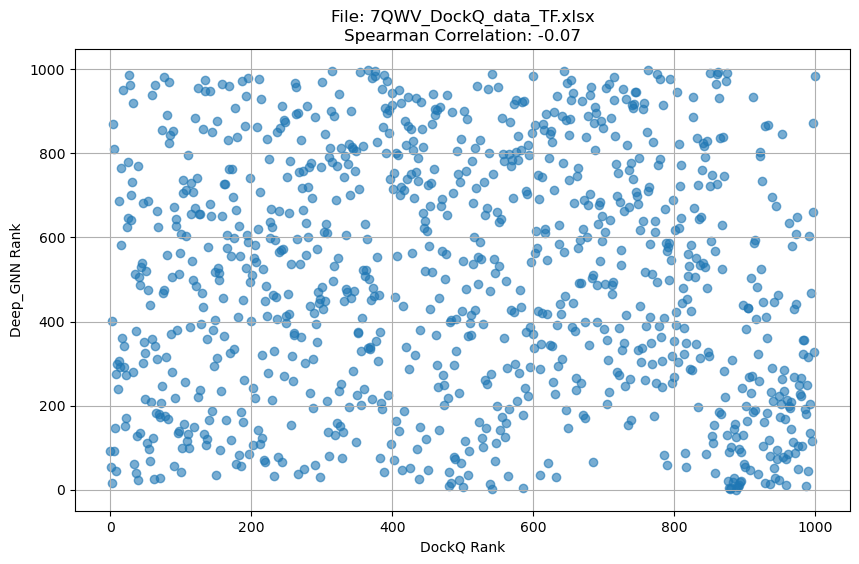

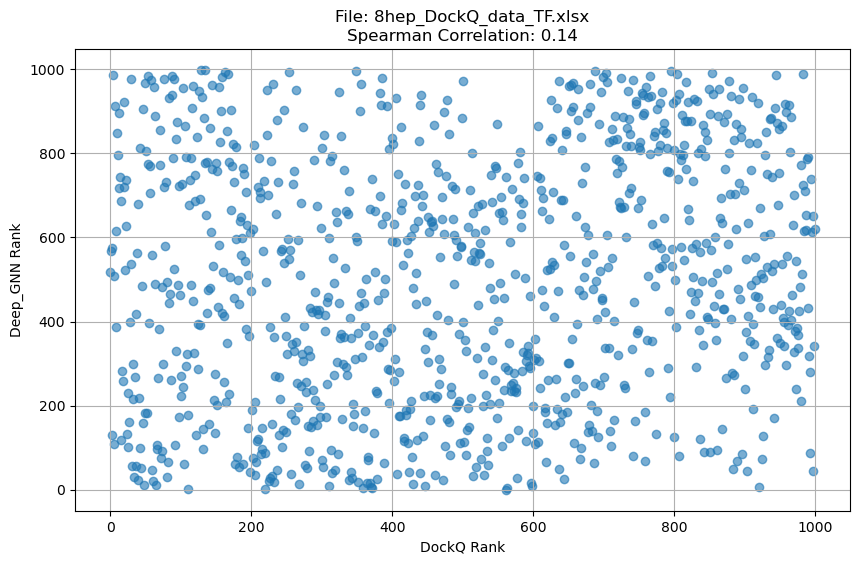

Summary of Spearman correlations saved to /Users/neginmanshour/Desktop/PpEv/Quality_Scoring_Functions/Spearman_Correlation/TF_Spearman/correlations_Deep_GNN_TF.xlsx


In [7]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from zipfile import BadZipFile

def process_excel_files(directory_path, output_directory):
    # Ensure the output directory exists
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)
    
    excel_files = [f for f in os.listdir(directory_path) if f.endswith('.xlsx')]
    correlations = []  # To store file names and their Spearman correlations
    
    for excel_file in excel_files:
        excel_file_path = os.path.join(directory_path, excel_file)
        
        try:
            xls = pd.ExcelFile(excel_file_path)
        except BadZipFile:
            print(f'Error: The file "{excel_file}" is not a valid Excel file or is corrupted.')
            continue
        except Exception as e:
            print(f'An unexpected error occurred while processing {excel_file}: {e}')
            continue
        
        if 'Deep_GNN' not in xls.sheet_names:
            print(f'The file "{excel_file}" does not contain a "Deep_GNN" sheet.')
            continue

        # Reading data from sheets
        dockq_df = pd.read_excel(excel_file_path, sheet_name='Sheet')
        Foldx_df = pd.read_excel(excel_file_path, sheet_name='Deep_GNN')
        
        # Mapping and correlation calculation
        alpha_to_dockq_map = dockq_df.set_index('AlphaFold Rank')['DockQ Rank'].to_dict()
        Foldx_df['DockQ Rank'] = Foldx_df['AlphaRank'].map(alpha_to_dockq_map)
        filtered_Foldx_df = Foldx_df.dropna(subset=['DockQ Rank'])
        spearman_corr, _ = spearmanr(filtered_Foldx_df['deep rank'], filtered_Foldx_df['DockQ Rank'])
        
        # Visualization
        plt.figure(figsize=(10, 6))
        plt.scatter(filtered_Foldx_df['DockQ Rank'], filtered_Foldx_df['deep rank'], alpha=0.6)
        plt.title(f'File: {excel_file}\nSpearman Correlation: {spearman_corr:.2f}')
        plt.xlabel('DockQ Rank')
        plt.ylabel('Deep_GNN Rank')
        plt.grid(True)
        plt.show()

        correlations.append({'File Name': excel_file, 'Spearman Correlation': spearman_corr})
    
    # Convert list to DataFrame and save
    correlations_df = pd.DataFrame(correlations)
    output_file_path = os.path.join(output_directory, 'correlations_Deep_GNN_TF.xlsx')
    correlations_df.to_excel(output_file_path, index=False)
    print(f'Summary of Spearman correlations saved to {output_file_path}')


directory_path = os.path.join(config['output_directories'], 'Deep_DockQ_TF')
output_directory = config['Spearman_Correlation_directory_TF']

process_excel_files(directory_path, output_directory)


In [8]:
import pandas as pd

def calculate_positive_negative_percentages_and_average(file_path):
    # Load the Excel file
    data = pd.read_excel(file_path)
    
    # Count the total number of entries
    total_entries = len(data['Spearman Correlation'])
    
    # Count the number of positive and negative Pyros_Spearman Correlation values
    positive_count = data[data['Spearman Correlation'] > 0].shape[0]
    negative_count = data[data['Spearman Correlation'] < 0].shape[0]
    
    # Calculate percentages
    positive_percentage = (positive_count / total_entries) * 100
    negative_percentage = (negative_count / total_entries) * 100
    
    # Calculate the average of Dove_Spearman Correlation values
    average_correlation = data['Spearman Correlation'].mean()
    
    return positive_percentage, negative_percentage, average_correlation

# Example usage
#file_path = '/Users/neginmanshour/Desktop/Deeprank/Deeprank_gnn/Deep_GNN/Correlation_TF/correlations_gnn_deep_TF.xlsx'  # Replace with the actual path to your Excel file
file_path = f"{config['Spearman_Correlation_directory_TF']}/correlations_Deep_GNN_TF.xlsx"
positive_percentage, negative_percentage, average_correlation = calculate_positive_negative_percentages_and_average(file_path)
print(f"Positive Deep_gnn_Spearman Correlation: {positive_percentage:.2f}%")
print(f"Negative Deep_gnn_Spearman Correlation: {negative_percentage:.2f}%")
print(f"Average Deep_gnn_Spearman Correlation: {average_correlation:.2f}")



Positive Deep_gnn_Spearman Correlation: 60.00%
Negative Deep_gnn_Spearman Correlation: 40.00%
Average Deep_gnn_Spearman Correlation: 0.04


In [9]:
import os
import pandas as pd

# Directory containing the Excel files
directory_path = f"{config['output_directories']}/Deep_DockQ_TF"

# Initialize a list to store the results
results = []

# List all Excel files in the directory
excel_files = [file for file in os.listdir(directory_path) if file.endswith('.xlsx')]

for file_name in excel_files:
    file_path = os.path.join(directory_path, file_name)
    
    try:
        xls = pd.ExcelFile(file_path)

        # Extract pdb_id from file name
        pdb_id = file_name.split('_')[0]

        # Load data from "Deep_GNN" sheet
        foldx_df = pd.read_excel(file_path, sheet_name='Deep_GNN')
        
        # Check if there are any rows where 'deep rank' is 0
        if not foldx_df[foldx_df['deep rank'] == 0].empty:
            structure_name_for_rank_zero = foldx_df[foldx_df['deep rank'] == 0]['CSV Name'].iloc[0].replace('.csv', '.pdb_clean')
        else:
            print(f"No rows found with 'deep rank' equal to 0 in file {file_name}")
            continue

        # Load data from "Sheet" sheet
        sheet_df = pd.read_excel(file_path, sheet_name='Sheet')

        # Check if the 'DockQ' column exists
        if 'DockQ' not in sheet_df.columns:
            print(f"No 'DockQ' column found in sheet 'Sheet' of file {file_name}")
            continue

        # Highest DockQ score
        highest_dockq_score = sheet_df['DockQ'].max()

        # DockQ score for the structure from Deep_GNN
        highest_foldx_dockq_score = sheet_df[sheet_df['File Name'].str.contains(structure_name_for_rank_zero)]['DockQ'].max()

        # Calculate Loss
        score_Loss = highest_dockq_score - highest_foldx_dockq_score

        # Append results
        results.append([pdb_id, highest_dockq_score, highest_foldx_dockq_score, score_Loss])

    except FileNotFoundError:
        print(f"The file at {file_path} was not found.")
    except KeyError as e:
        print(f"Missing column in the dataframe: {e}")
    except Exception as e:
        print(f"An error occurred with file {file_name}: {e}")

# Create a DataFrame from the results
results_df = pd.DataFrame(results, columns=['File Name', 'DockQ', 'Deep_GNN ranked', 'Loss'])

# Save the results into a new Excel file
output_directory = config["DockQ_Loss_directory_TF"]
output_path = os.path.join(output_directory, 'Deep_GNN_TF.xlsx')
results_df.to_excel(output_path, index=False)

print(f"Results have been saved to {output_path}")


Results have been saved to /Users/neginmanshour/Desktop/PpEv/Quality_Scoring_Functions/Loss/TF_Loss/Deep_GNN_TF.xlsx
